## Imports

In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: 
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE 

Tensorflow version 2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Run this when all work is done
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
%cp /content/drive/MyDrive/dataset/bn_target_images_us.zip /tmp
%cp /content/drive/MyDrive/dataset/mg_target_images_us.zip /tmp

In [ ]:
%mkdir /tmp/Prostate

In [ ]:
!unzip /tmp/bn_target_images_us.zip -d /tmp/Prostate
!unzip /tmp/mg_target_images_us.zip -d /tmp/Prostate

Archive:  /tmp/bn_target_images_us.zip
   creating: /tmp/Prostate/bn_target_images_us/
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_1.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_10.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_100.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_1000.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_1001.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_1002.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_1003.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_1004.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_1005.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_1006.PNG  
  inflating: /tmp/Prostate/bn_target_images_us/PROSTATE_CANCER_US_BENIGN_1007.P

## Configuration

In [ ]:
%mkdir /tmp/prostate_tfrecords

In [ ]:
GCS_PATTERN = '/tmp/Prostate/*/*.PNG'
GCS_OUTPUT = '/tmp/prostate_tfrecords/prostate'  # prefix for output file names
SHARDS = 16
TARGET_SIZE = [224, 224]

CLASSES = [b'benign', b'malignant'] # do not change, maps to the labels in the data (folder names)
print(CLASSES)

[b'benign', b'malignant']


In [ ]:
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Read images and labels

In [ ]:
print(GCS_PATTERN)
nb_images = len(tf.io.gfile.glob(GCS_PATTERN))
print(nb_images)
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print(shard_size)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  print(label)
  label = label.values[-2]
  print('Label',label)
  return image, label

filenames = tf.data.Dataset.list_files(GCS_PATTERN, seed=10655) # This also shuffles the images
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)
print(shard_size)

/tmp/Prostate/*/*.PNG
4035
253
Pattern matches 4035 images which will be rewritten as 16 .tfrec files containing 253 images each.
tf.RaggedTensor(values=Tensor("StringSplit/StringSplitV2:1", shape=(None,), dtype=string), row_splits=Tensor("StringSplit/RaggedFromValueRowIds/RowPartitionFromValueRowIds/concat:0", shape=(None,), dtype=int64))
Label Tensor("strided_slice:0", shape=(), dtype=string)
253


In [ ]:
type(dataset1)
print(dataset1)

<ParallelMapDataset shapes: ((None, None, None), ()), types: (tf.uint8, tf.string)>


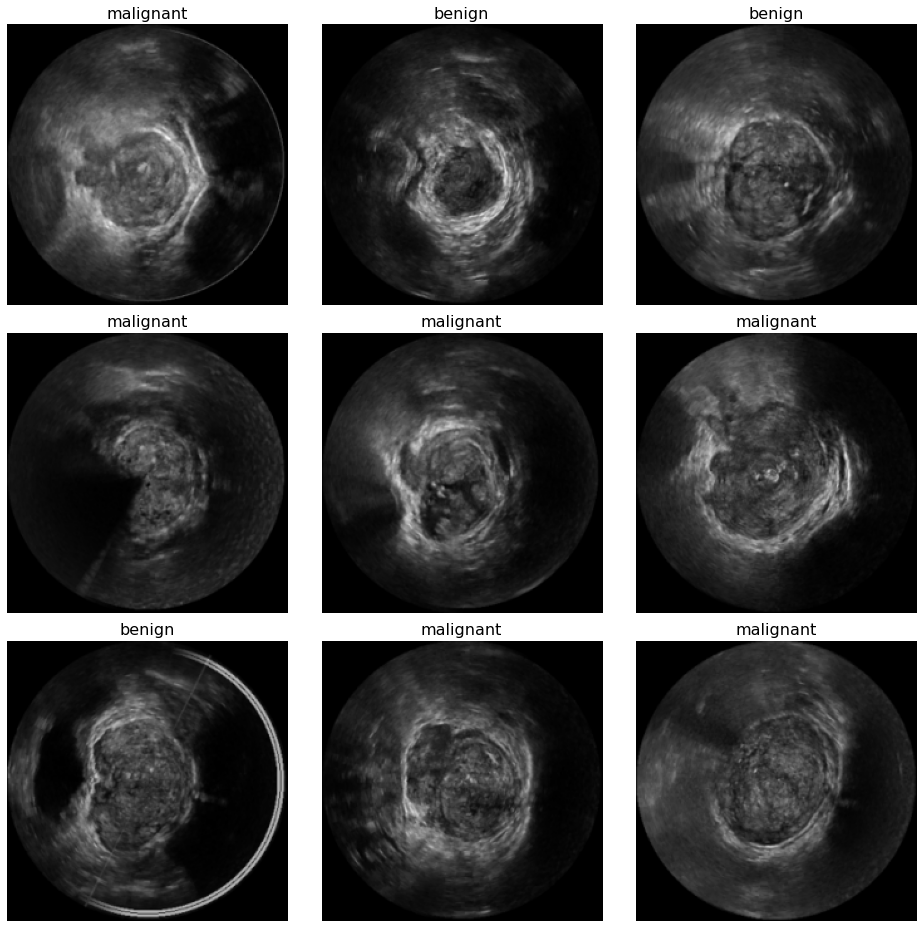

In [ ]:
display_9_images_from_dataset(dataset1)

## Resize and crop images to common size
No need to study the code in this cell. It's only image resizing.

In [ ]:
def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  

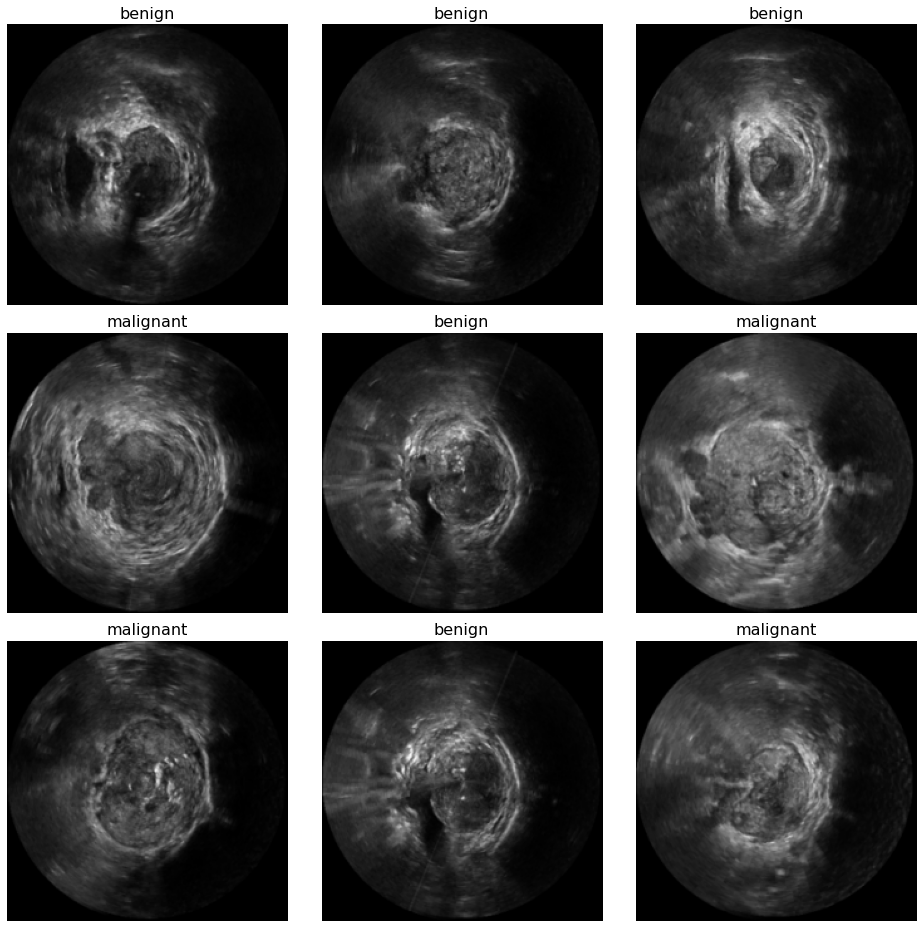

In [ ]:
display_9_images_from_dataset(dataset2)

### Speed test-Slow: Training on thousands of individual files will not work. We have to use the **TFRecord** format to group files together. 

In [ ]:
display_dataset = dataset2.batch(8)
for image, label in display_dataset.take(30):
  print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 224, 224, 3), ['malignant', 'malignant', 'benign', 'malignant', 'malignant', 'malignant', 'malignant', 'benign'])
Image batch shape (8, 224, 224, 3), ['benign', 'benign', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'malignant'])
Image batch shape (8, 224, 224, 3), ['malignant', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'benign', 'benign'])
Image batch shape (8, 224, 224, 3), ['malignant', 'benign', 'malignant', 'benign', 'malignant', 'benign', 'malignant', 'benign'])
Image batch shape (8, 224, 224, 3), ['benign', 'malignant', 'benign', 'benign', 'benign', 'benign', 'benign', 'malignant'])
Image batch shape (8, 224, 224, 3), ['benign', 'benign', 'benign', 'benign', 'malignant', 'benign', 'malignant', 'benign'])
Image batch shape (8, 224, 224, 3), ['malignant', 'malignant', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'benign'])
Image batch shape (8, 224, 224, 3), ['malignant', 'benign', 'benign', 'malignant', 'malignant

## Recompress the images for bandwidth savings by outweight the decoding CPU cost

In [ ]:
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 
print(dataset3)

<BatchDataset shapes: ((None,), (None,), (None,), (None,)), types: (tf.string, tf.string, tf.int32, tf.int32)>


## Write dataset as TFRecord files

In [ ]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num] # [0, 0, 1, 0, 0] for class #2

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
      "one_hot_class": _float_feature(one_hot_class.tolist()) # variable length  list of floats, n=len(CLASSES)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
for shard, (image, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file /tmp/prostate_tfrecords/prostate00-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate01-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate02-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate03-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate04-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate05-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate06-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate07-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate08-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate09-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate10-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords/prostate11-253.tfrec containing 253 records
Wrote file /tmp/prostate_tfrecords

## Read  from TFRecord Dataset
**Resume running the cells**

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

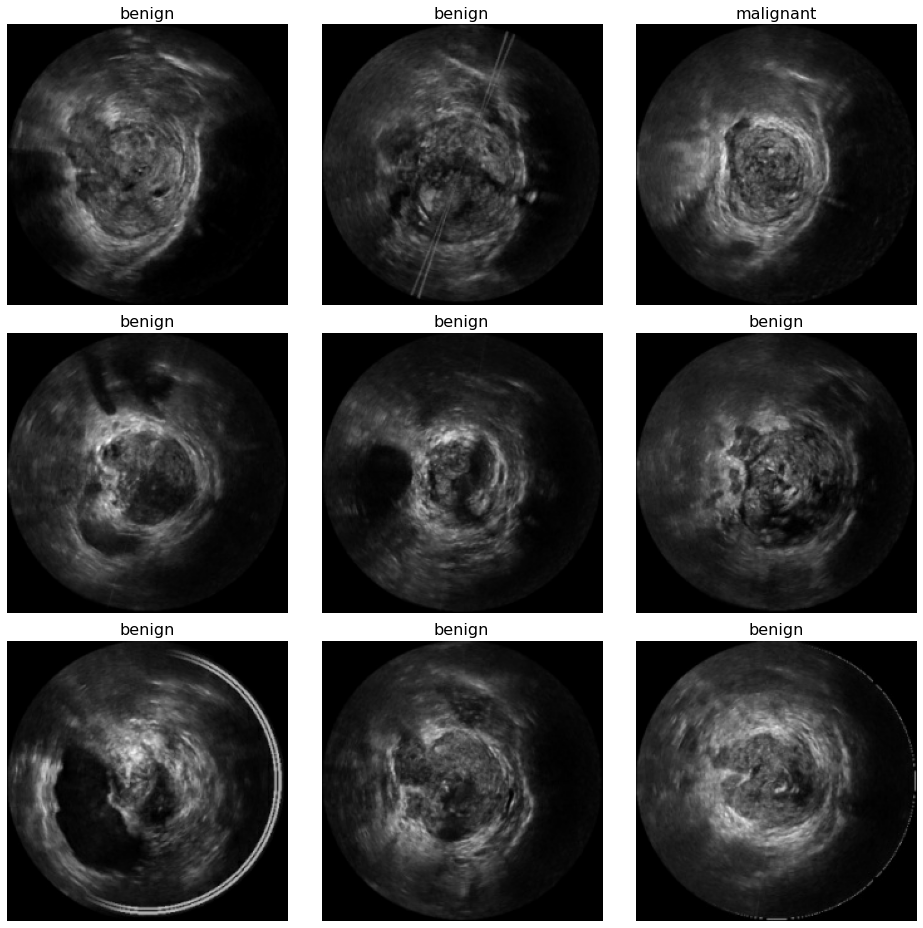

In [ ]:
display_dataset = dataset4.map(lambda image, class_num, label, height, width, one_hot_class: (image, label))
display_9_images_from_dataset(display_dataset)

### Speed test: fast
Loading training data is not a bottleneck anymore

In [ ]:
for image, class_num, label, height, width, one_hot_class in dataset4.take(300):
    print("Image shape {}, {}x{} px, class={} ({:>10}, {})".format(image.numpy().shape, width, height, class_num, label.numpy().decode('utf8'), one_hot_class))

Image shape (224, 224, 3), 224x224 px, class=0 (    benign, [1. 0.])
Image shape (224, 224, 3), 224x224 px, class=0 (    benign, [1. 0.])
Image shape (224, 224, 3), 224x224 px, class=1 ( malignant, [0. 1.])
Image shape (224, 224, 3), 224x224 px, class=0 (    benign, [1. 0.])
Image shape (224, 224, 3), 224x224 px, class=0 (    benign, [1. 0.])
Image shape (224, 224, 3), 224x224 px, class=0 (    benign, [1. 0.])
Image shape (224, 224, 3), 224x224 px, class=1 ( malignant, [0. 1.])
Image shape (224, 224, 3), 224x224 px, class=0 (    benign, [1. 0.])
Image shape (224, 224, 3), 224x224 px, class=1 ( malignant, [0. 1.])
Image shape (224, 224, 3), 224x224 px, class=1 ( malignant, [0. 1.])
Image shape (224, 224, 3), 224x224 px, class=1 ( malignant, [0. 1.])
Image shape (224, 224, 3), 224x224 px, class=1 ( malignant, [0. 1.])
Image shape (224, 224, 3), 224x224 px, class=1 ( malignant, [0. 1.])
Image shape (224, 224, 3), 224x224 px, class=0 (    benign, [1. 0.])
Image shape (224, 224, 3), 224x224

In [ ]:
IMAGE_FILE_LOCATION = '/tmp/Prostate/*/*.PNG'
TF_RECORD_LOCATION = '/tmp/prostate_tfrecords/*.tfrec'

IMAGE_SIZE = [224, 224]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS=12

VALIDATION_SPLIT = 0.20
CLASSES = [b'benign', b'malignant']
NO_OF_CLASSES=len(CLASSES)

total_image_files = len(tf.io.gfile.glob(IMAGE_FILE_LOCATION))

# splitting data files between training and validation
filenames = tf.io.gfile.glob(TF_RECORD_LOCATION)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(total_image_files // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(total_image_files // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 51 batches per training epoch and 11 batch(es) per validation run.


In [ ]:
def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [ ]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    return image, class_label

def load_dataset(filenames):

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

['/tmp/prostate_tfrecords/prostate09-253.tfrec', '/tmp/prostate_tfrecords/prostate15-240.tfrec', '/tmp/prostate_tfrecords/prostate05-253.tfrec', '/tmp/prostate_tfrecords/prostate04-253.tfrec', '/tmp/prostate_tfrecords/prostate03-253.tfrec', '/tmp/prostate_tfrecords/prostate07-253.tfrec', '/tmp/prostate_tfrecords/prostate13-253.tfrec', '/tmp/prostate_tfrecords/prostate00-253.tfrec', '/tmp/prostate_tfrecords/prostate08-253.tfrec', '/tmp/prostate_tfrecords/prostate01-253.tfrec', '/tmp/prostate_tfrecords/prostate02-253.tfrec', '/tmp/prostate_tfrecords/prostate12-253.tfrec', '/tmp/prostate_tfrecords/prostate14-253.tfrec']


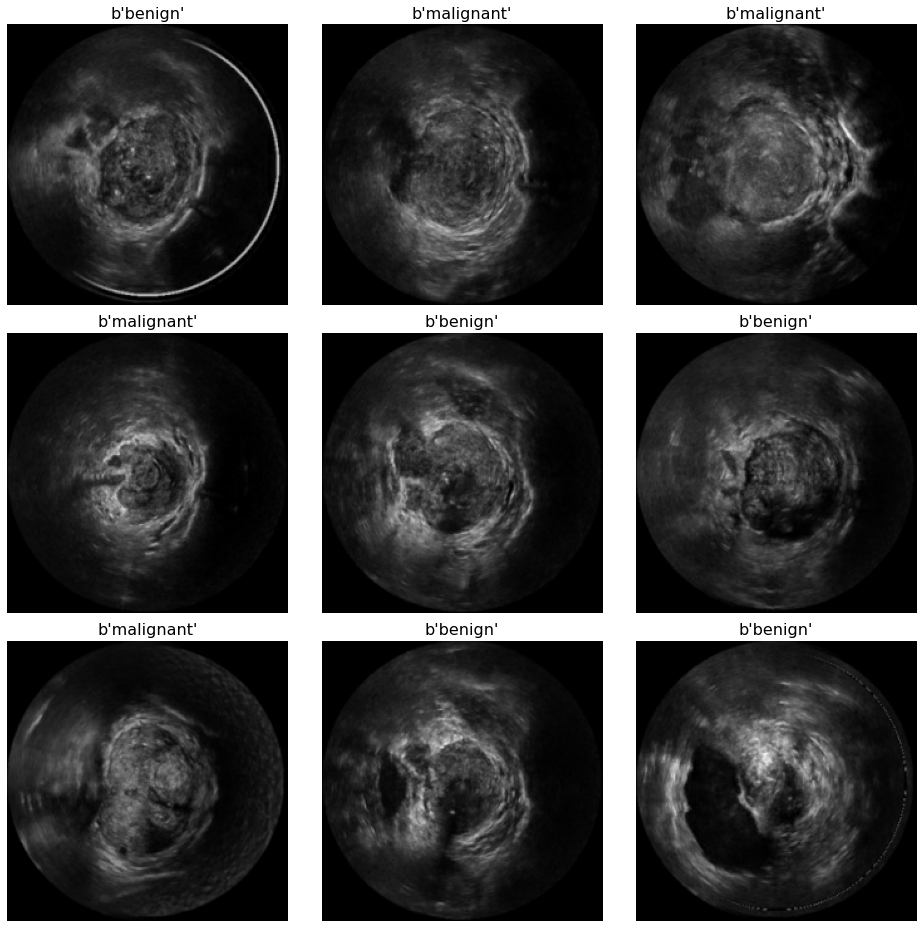

In [ ]:
print(training_filenames)
display_9_images_from_dataset(load_dataset(training_filenames))

['/tmp/prostate_tfrecords/prostate06-253.tfrec', '/tmp/prostate_tfrecords/prostate10-253.tfrec', '/tmp/prostate_tfrecords/prostate11-253.tfrec']


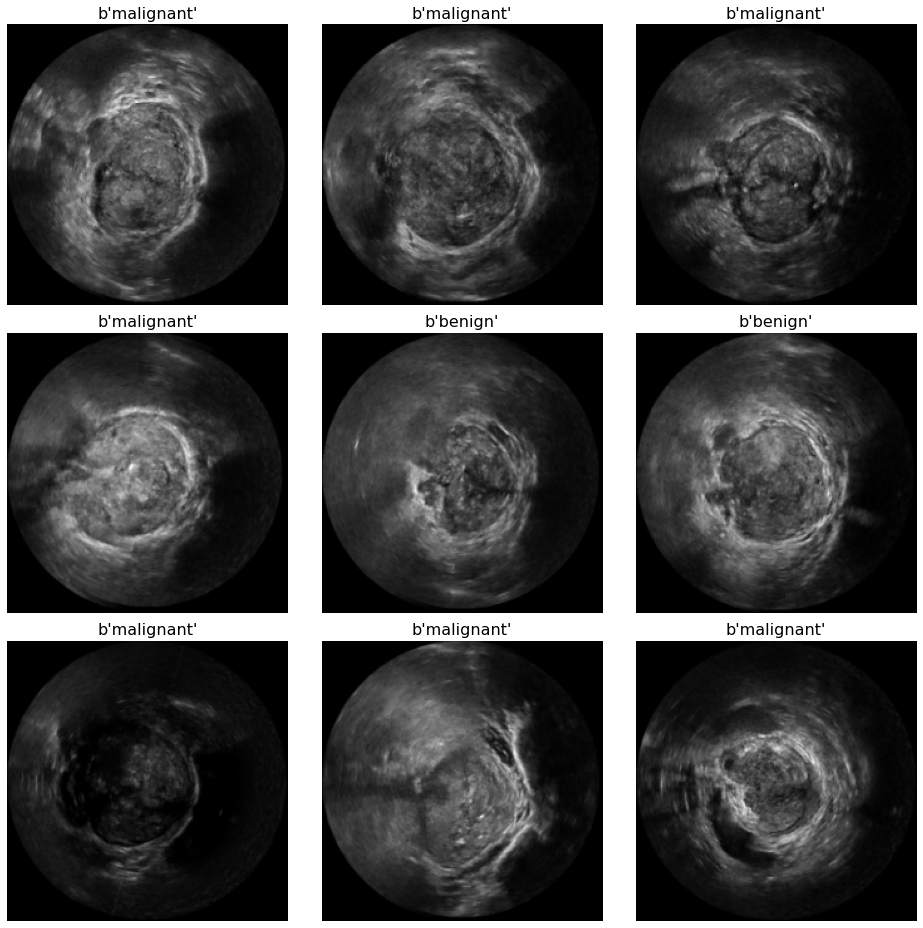

In [ ]:
print(validation_filenames)
display_9_images_from_dataset(load_dataset(validation_filenames))

In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

print(training_dataset)
print(validation_dataset)


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_MobileNetV2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_MobileNetV2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_MobileNetV2.summary()
model_MobileNetV2.input_shape

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16056576  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 18,315,074
Trainable params: 16,057,090
Non-trainable params: 2,257,984
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
import time
start_time = time.time()
history = model_MobileNetV2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_MobileNetV2_accuracy=round(np.mean(final_accuracy),2)
model_MobileNetV2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(MobileNetV2): ", model_MobileNetV2_accuracy)
print("TRAINING TIME: ", model_MobileNetV2_training_time , " sec")

Epoch 1/12
51/51 [==============================] - 38s 111ms/step - loss: 6.0978 - accuracy: 0.6480 - val_loss: 0.3677 - val_accuracy: 0.8352
Epoch 2/12
51/51 [==============================] - 5s 101ms/step - loss: 0.3309 - accuracy: 0.8529 - val_loss: 0.2106 - val_accuracy: 0.9403
Epoch 3/12
51/51 [==============================] - 5s 100ms/step - loss: 0.2144 - accuracy: 0.9191 - val_loss: 0.1202 - val_accuracy: 0.9787
Epoch 4/12
51/51 [==============================] - 5s 100ms/step - loss: 0.1480 - accuracy: 0.9458 - val_loss: 0.0807 - val_accuracy: 0.9915
Epoch 5/12
51/51 [==============================] - 5s 100ms/step - loss: 0.1242 - accuracy: 0.9632 - val_loss: 0.0688 - val_accuracy: 0.9929
Epoch 6/12
51/51 [==============================] - 5s 101ms/step - loss: 0.1067 - accuracy: 0.9703 - val_loss: 0.0584 - val_accuracy: 0.9915
Epoch 7/12
51/51 [==============================] - 5s 100ms/step - loss: 0.0925 - accuracy: 0.9770 - val_loss: 0.0412 - val_accuracy: 0.9929
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


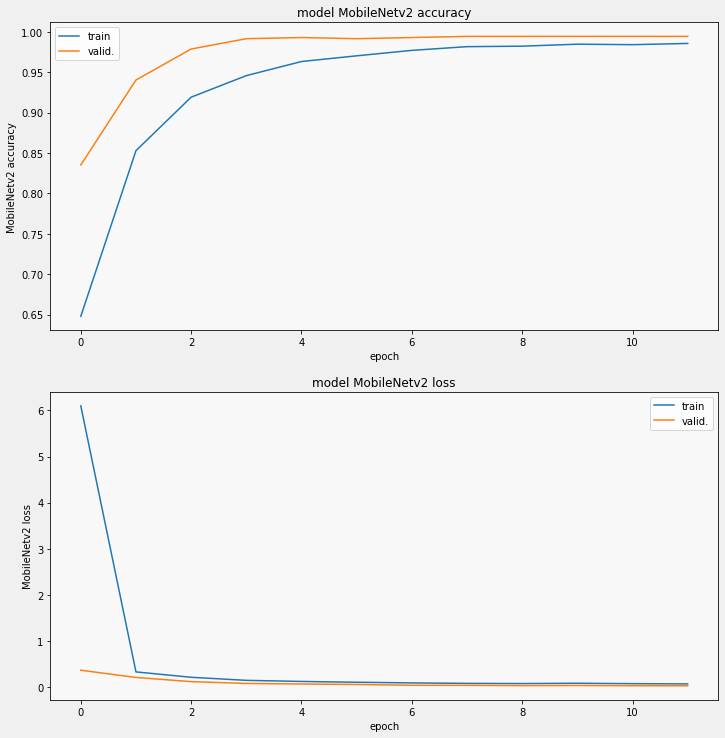

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'MobileNetv2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'MobileNetv2 loss', 212)

[b'malignant', b'malignant', b'malignant', b'benign', b'benign', b'malignant', b'malignant', b'malignant', b'malignant']


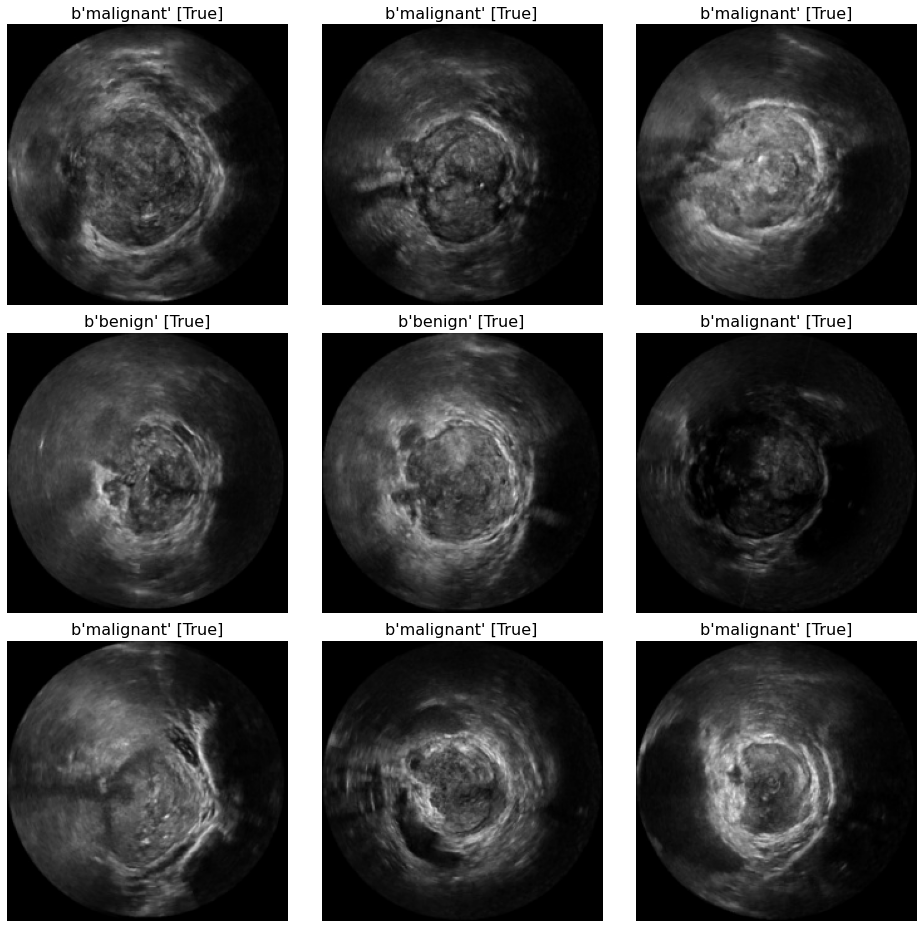

In [ ]:
diseases, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(16)), 9)

predictions = model_MobileNetV2.predict(diseases, steps=1 )
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

display_9_images_with_predictions(diseases, predictions, labels)

In [ ]:
pretrained_model = tf.keras.applications.VGG16(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_VGG16 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_VGG16.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_VGG16.summary()
model_VGG16.input_shape

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
import time
start_time = time.time()
history = model_VGG16.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]


model_VGG16_accuracy=round(np.mean(final_accuracy),2)
model_VGG16_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(VGG16): ", model_VGG16_accuracy)
print("TRAINING TIME: ", model_VGG16_training_time , " sec")

Epoch 1/12
51/51 [==============================] - 29s 342ms/step - loss: 1.2667 - accuracy: 0.6170 - val_loss: 0.5457 - val_accuracy: 0.7855
Epoch 2/12
51/51 [==============================] - 16s 324ms/step - loss: 0.4913 - accuracy: 0.7822 - val_loss: 0.4158 - val_accuracy: 0.8253
Epoch 3/12
51/51 [==============================] - 16s 321ms/step - loss: 0.3699 - accuracy: 0.8487 - val_loss: 0.3087 - val_accuracy: 0.8906
Epoch 4/12
51/51 [==============================] - 16s 324ms/step - loss: 0.2802 - accuracy: 0.9029 - val_loss: 0.2372 - val_accuracy: 0.9048
Epoch 5/12
51/51 [==============================] - 17s 330ms/step - loss: 0.2054 - accuracy: 0.9387 - val_loss: 0.1690 - val_accuracy: 0.9616
Epoch 6/12
51/51 [==============================] - 17s 330ms/step - loss: 0.1520 - accuracy: 0.9632 - val_loss: 0.1256 - val_accuracy: 0.9744
Epoch 7/12
51/51 [==============================] - 17s 327ms/step - loss: 0.1245 - accuracy: 0.9703 - val_loss: 0.0873 - val_accuracy: 0.9858

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


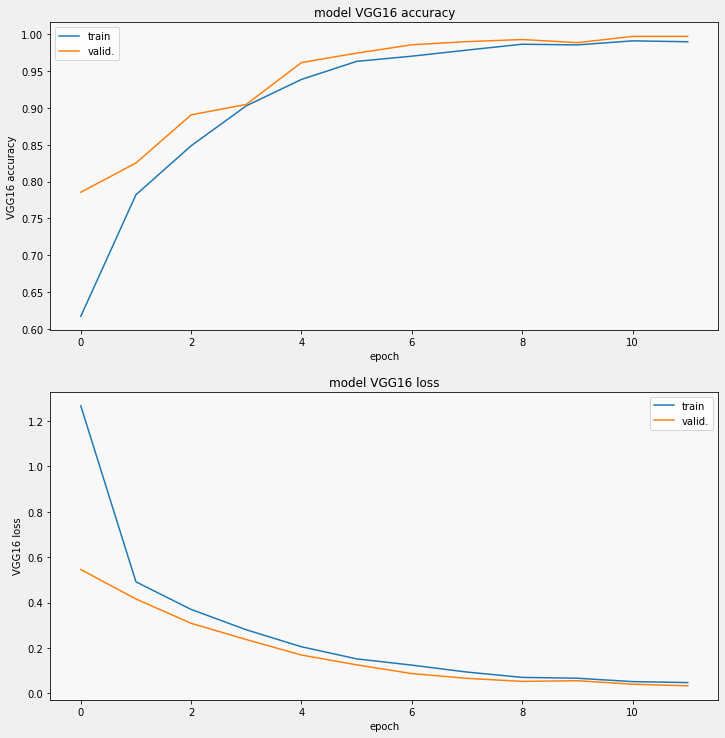

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'VGG16 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'VGG16 loss', 212)

[b'malignant', b'malignant', b'malignant', b'malignant', b'benign', b'benign', b'malignant', b'malignant', b'malignant']


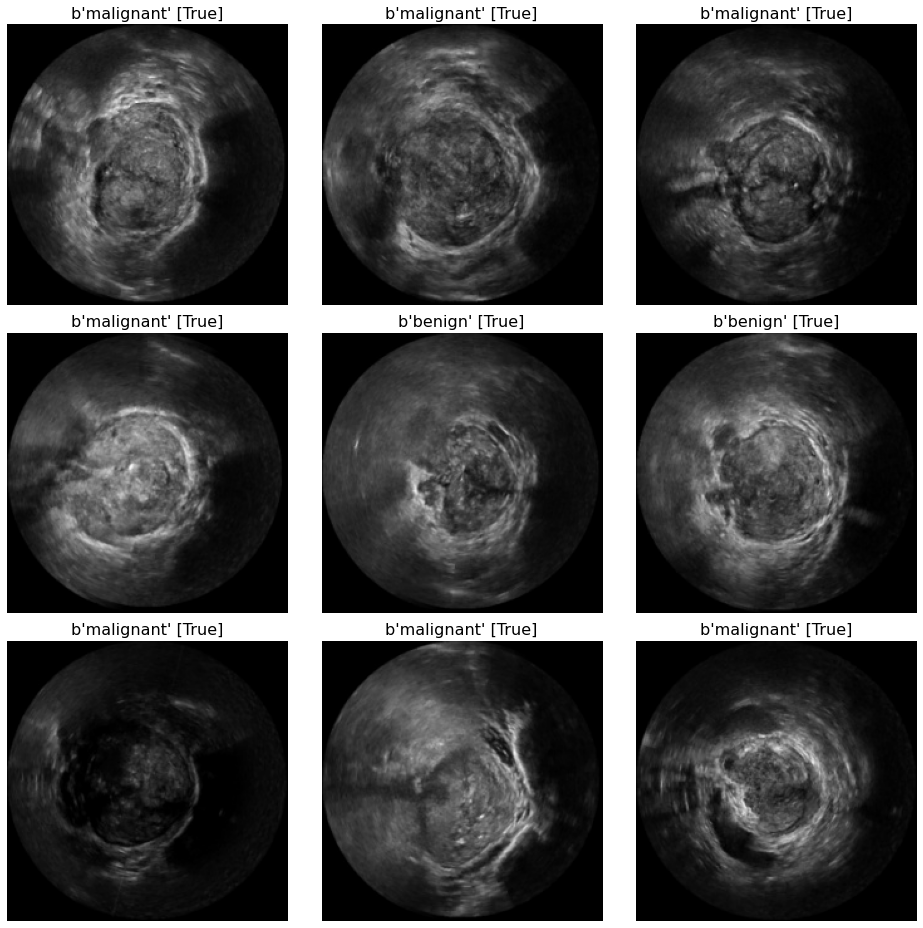

In [ ]:
prostate, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(16)), 9)

predictions = model_VGG16.predict(prostate, steps=1 )
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

display_9_images_with_predictions(prostate, predictions, labels)

In [ ]:
pretrained_model = tf.keras.applications.ResNet50V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet50V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet50V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet50V2.summary()
model_ResNet50V2.input_shape

94674944/94668760 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 49,255,682
Trainable params: 25,690,882
Non-trainable params: 23,564,800
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
start_time = time.time()
history = model_ResNet50V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_ResNet50V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet50V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet50V2): ", model_ResNet50V2_accuracy)
print("TRAINING TIME: ", model_ResNet50V2_training_time , " sec")


Epoch 1/12
51/51 [==============================] - 16s 234ms/step - loss: 6.0476 - accuracy: 0.6850 - val_loss: 0.3261 - val_accuracy: 0.8523
Epoch 2/12
51/51 [==============================] - 12s 226ms/step - loss: 0.3280 - accuracy: 0.8398 - val_loss: 0.1641 - val_accuracy: 0.9403
Epoch 3/12
51/51 [==============================] - 12s 230ms/step - loss: 0.2035 - accuracy: 0.9234 - val_loss: 0.0837 - val_accuracy: 0.9773
Epoch 4/12
51/51 [==============================] - 11s 223ms/step - loss: 0.1181 - accuracy: 0.9568 - val_loss: 0.0665 - val_accuracy: 0.9915
Epoch 5/12
51/51 [==============================] - 11s 221ms/step - loss: 0.0810 - accuracy: 0.9746 - val_loss: 0.0378 - val_accuracy: 0.9929
Epoch 6/12
51/51 [==============================] - 11s 220ms/step - loss: 0.0723 - accuracy: 0.9730 - val_loss: 0.0223 - val_accuracy: 0.9943
Epoch 7/12
51/51 [==============================] - 11s 220ms/step - loss: 0.0501 - accuracy: 0.9844 - val_loss: 0.0206 - val_accuracy: 0.9943

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


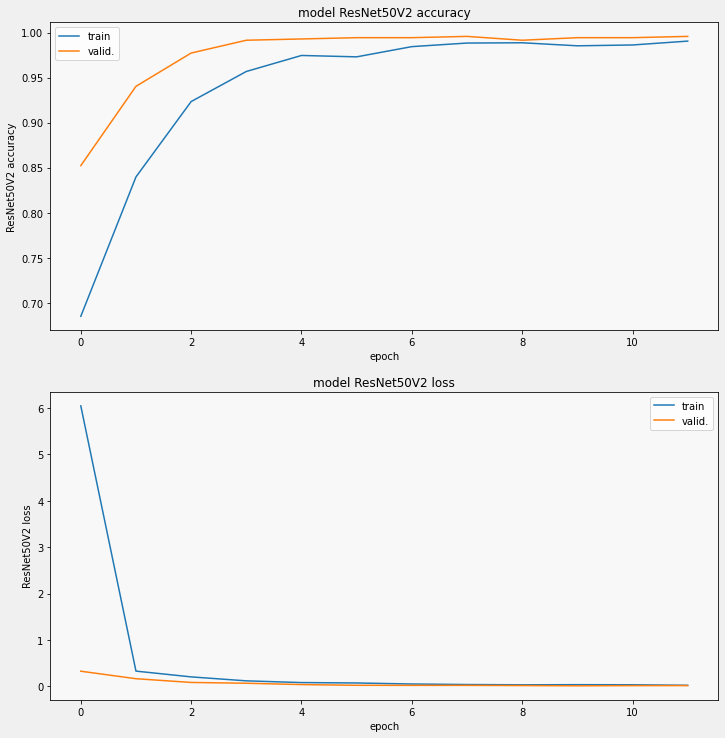

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet50V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet50V2 loss', 212)

In [ ]:
pretrained_model = tf.keras.applications.ResNet101V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet101V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet101V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet101V2.summary()
model_ResNet101V2.input_shape

171319296/171317808 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 68,317,442
Trainable params: 25,690,882
Non-trainable params: 42,626,560
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
start_time = time.time()
history = model_ResNet101V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]
model_ResNet101V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet101V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet101V2): ", model_ResNet101V2_accuracy)
print("TRAINING TIME: ", model_ResNet101V2_training_time , " sec")

Epoch 1/12
51/51 [==============================] - 25s 406ms/step - loss: 7.0255 - accuracy: 0.6903 - val_loss: 0.3133 - val_accuracy: 0.9006
Epoch 2/12
51/51 [==============================] - 20s 402ms/step - loss: 0.3044 - accuracy: 0.8741 - val_loss: 0.1831 - val_accuracy: 0.9347
Epoch 3/12
51/51 [==============================] - 20s 389ms/step - loss: 0.1760 - accuracy: 0.9341 - val_loss: 0.1142 - val_accuracy: 0.9716
Epoch 4/12
51/51 [==============================] - 19s 378ms/step - loss: 0.1204 - accuracy: 0.9608 - val_loss: 0.0820 - val_accuracy: 0.9844
Epoch 5/12
51/51 [==============================] - 19s 384ms/step - loss: 0.0918 - accuracy: 0.9657 - val_loss: 0.0659 - val_accuracy: 0.9858
Epoch 6/12
51/51 [==============================] - 20s 393ms/step - loss: 0.0835 - accuracy: 0.9712 - val_loss: 0.1037 - val_accuracy: 0.9616
Epoch 7/12
51/51 [==============================] - 20s 389ms/step - loss: 0.0628 - accuracy: 0.9807 - val_loss: 0.0326 - val_accuracy: 0.9901

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


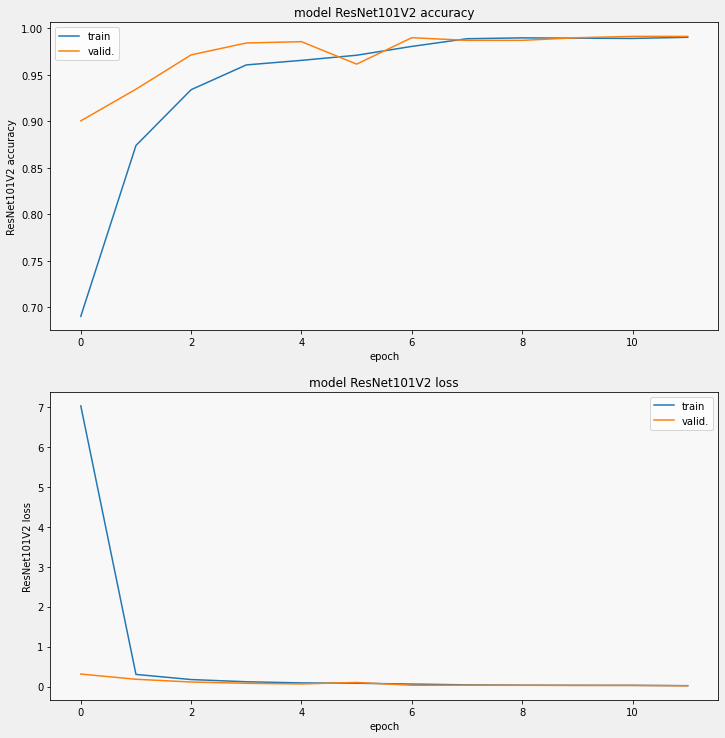

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet101V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet101V2 loss', 212)

In [ ]:
pretrained_model = tf.keras.applications.ResNet152V2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_ResNet152V2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_ResNet152V2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_ResNet152V2.summary()
model_ResNet152V2.input_shape

234553344/234545216 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 514       
Total params: 84,022,530
Trainable params: 25,690,882
Non-trainable params: 58,331,648
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
start_time = time.time()
history = model_ResNet152V2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_ResNet152V2_accuracy=round(np.mean(final_accuracy),2)
model_ResNet152V2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(ResNet152V2): ", model_ResNet152V2_accuracy)
print("TRAINING TIME: ", model_ResNet152V2_training_time , " sec")

Epoch 1/12
51/51 [==============================] - 38s 601ms/step - loss: 4.0676 - accuracy: 0.7423 - val_loss: 0.2544 - val_accuracy: 0.9077
Epoch 2/12
51/51 [==============================] - 29s 566ms/step - loss: 0.2242 - accuracy: 0.9170 - val_loss: 0.1063 - val_accuracy: 0.9730
Epoch 3/12
51/51 [==============================] - 28s 549ms/step - loss: 0.1070 - accuracy: 0.9654 - val_loss: 0.0557 - val_accuracy: 0.9858
Epoch 4/12
51/51 [==============================] - 28s 557ms/step - loss: 0.0810 - accuracy: 0.9730 - val_loss: 0.0389 - val_accuracy: 0.9858
Epoch 5/12
51/51 [==============================] - 28s 559ms/step - loss: 0.0532 - accuracy: 0.9813 - val_loss: 0.0327 - val_accuracy: 0.9901
Epoch 6/12
51/51 [==============================] - 28s 556ms/step - loss: 0.0467 - accuracy: 0.9847 - val_loss: 0.0319 - val_accuracy: 0.9872
Epoch 7/12
51/51 [==============================] - 28s 555ms/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 0.0209 - val_accuracy: 0.9915

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


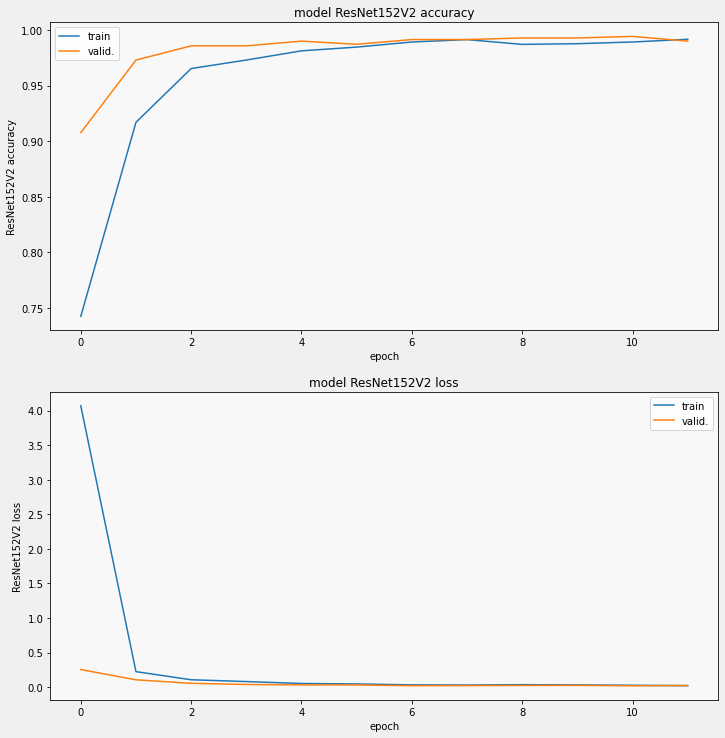

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'ResNet152V2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'ResNet152V2 loss', 212)

In [ ]:
pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_Xception = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_Xception.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_Xception.summary()
model_Xception.input_shape

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 514       
Total params: 46,552,362
Trainable params: 25,690,882
Non-trainable params: 20,861,480
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
start_time = time.time()
history = model_Xception.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_Xception_accuracy=round(np.mean(final_accuracy),2)
model_Xception_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(Xception): ", model_Xception_accuracy)
print("TRAINING TIME: ", model_Xception_training_time , " sec")

Epoch 1/12
51/51 [==============================] - 24s 386ms/step - loss: 4.9399 - accuracy: 0.6526 - val_loss: 0.4469 - val_accuracy: 0.8196
Epoch 2/12
51/51 [==============================] - 20s 397ms/step - loss: 0.4673 - accuracy: 0.7779 - val_loss: 0.3360 - val_accuracy: 0.8750
Epoch 3/12
51/51 [==============================] - 19s 378ms/step - loss: 0.3815 - accuracy: 0.8183 - val_loss: 0.3219 - val_accuracy: 0.8693
Epoch 4/12
51/51 [==============================] - 19s 370ms/step - loss: 0.3719 - accuracy: 0.8419 - val_loss: 0.2503 - val_accuracy: 0.9290
Epoch 5/12
51/51 [==============================] - 19s 374ms/step - loss: 0.3330 - accuracy: 0.8686 - val_loss: 0.2178 - val_accuracy: 0.9489
Epoch 6/12
51/51 [==============================] - 19s 384ms/step - loss: 0.2966 - accuracy: 0.8704 - val_loss: 0.2147 - val_accuracy: 0.9219
Epoch 7/12
51/51 [==============================] - 19s 380ms/step - loss: 0.2861 - accuracy: 0.8707 - val_loss: 0.1745 - val_accuracy: 0.9489

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


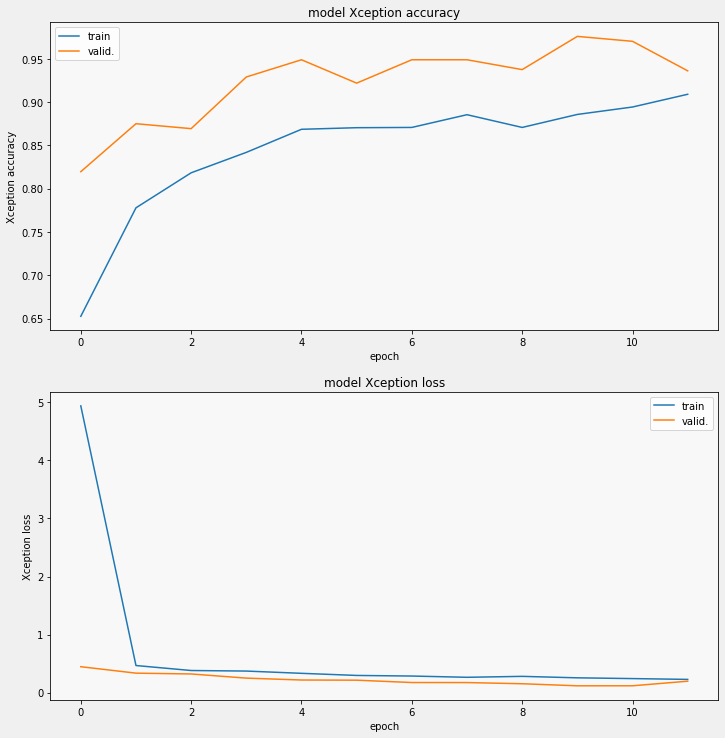

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Xception accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'Xception loss', 212)

In [ ]:
pretrained_model = tf.keras.applications.VGG19(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_VGG19 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_VGG19.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_VGG19.summary()
model_VGG19.input_shape

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 514       
Total params: 26,447,682
Trainable params: 6,423,298
Non-trainable params: 20,024,384
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
start_time = time.time()
history = model_VGG19.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_VGG19_accuracy=round(np.mean(final_accuracy),2)
model_VGG19_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(VGG19): ", model_VGG19_accuracy)
print("TRAINING TIME: ", model_VGG19_training_time , " sec")

Epoch 1/12
51/51 [==============================] - 20s 392ms/step - loss: 1.3563 - accuracy: 0.6017 - val_loss: 0.5535 - val_accuracy: 0.7514
Epoch 2/12
51/51 [==============================] - 21s 413ms/step - loss: 0.5496 - accuracy: 0.7148 - val_loss: 0.4663 - val_accuracy: 0.7969
Epoch 3/12
51/51 [==============================] - 20s 395ms/step - loss: 0.4659 - accuracy: 0.7785 - val_loss: 0.3785 - val_accuracy: 0.8452
Epoch 4/12
51/51 [==============================] - 20s 385ms/step - loss: 0.3914 - accuracy: 0.8244 - val_loss: 0.3026 - val_accuracy: 0.8878
Epoch 5/12
51/51 [==============================] - 20s 392ms/step - loss: 0.3506 - accuracy: 0.8529 - val_loss: 0.2867 - val_accuracy: 0.9062
Epoch 6/12
51/51 [==============================] - 20s 399ms/step - loss: 0.3288 - accuracy: 0.8652 - val_loss: 0.2538 - val_accuracy: 0.9205
Epoch 7/12
51/51 [==============================] - 20s 394ms/step - loss: 0.2973 - accuracy: 0.8695 - val_loss: 0.2407 - val_accuracy: 0.9062

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


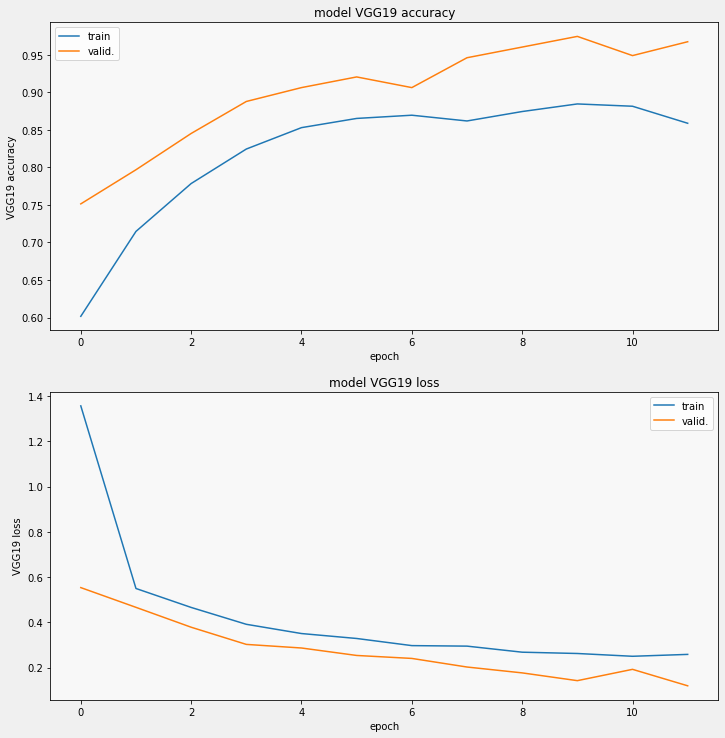

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'VGG19 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'VGG19 loss', 212)

In [ ]:
pretrained_model = tf.keras.applications.InceptionResNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_InceptionResNetV2 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_InceptionResNetV2.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_InceptionResNetV2.summary()
model_InceptionResNetV2.input_shape

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten_8 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               9830656   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 514       
Total params: 64,167,906
Trainable params: 9,831,170
Non-trainable params: 54,336,736
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
start_time = time.time()
history = model_InceptionResNetV2.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_InceptionResNetV2_accuracy=round(np.mean(final_accuracy),2)
model_InceptionResNetV2_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(InceptionResNetV2): ", model_InceptionResNetV2_accuracy)
print("TRAINING TIME: ", model_InceptionResNetV2_training_time , " sec")

Epoch 1/12
51/51 [==============================] - 34s 468ms/step - loss: 8.9010 - accuracy: 0.5536 - val_loss: 0.6355 - val_accuracy: 0.5895
Epoch 2/12
51/51 [==============================] - 22s 430ms/step - loss: 0.6378 - accuracy: 0.6042 - val_loss: 0.5323 - val_accuracy: 0.7287
Epoch 3/12
51/51 [==============================] - 21s 412ms/step - loss: 0.5667 - accuracy: 0.6924 - val_loss: 0.4836 - val_accuracy: 0.8452
Epoch 4/12
51/51 [==============================] - 21s 409ms/step - loss: 0.5303 - accuracy: 0.7362 - val_loss: 0.4621 - val_accuracy: 0.8409
Epoch 5/12
51/51 [==============================] - 21s 415ms/step - loss: 0.4916 - accuracy: 0.7956 - val_loss: 0.4144 - val_accuracy: 0.8324
Epoch 6/12
51/51 [==============================] - 21s 418ms/step - loss: 0.4504 - accuracy: 0.8211 - val_loss: 0.3838 - val_accuracy: 0.9347
Epoch 7/12
51/51 [==============================] - 21s 413ms/step - loss: 0.4290 - accuracy: 0.8229 - val_loss: 0.3549 - val_accuracy: 0.8466

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


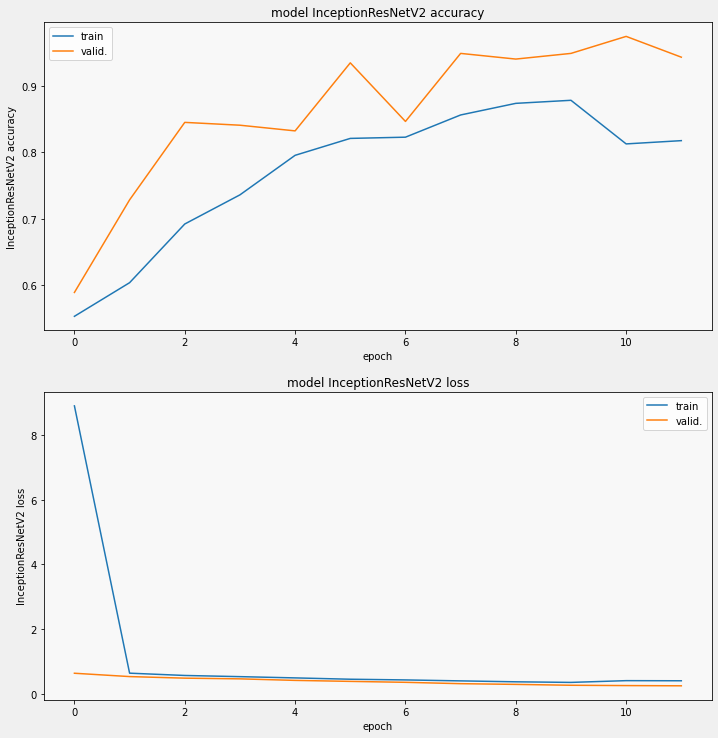

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'InceptionResNetV2 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'InceptionResNetV2 loss', 212)

In [ ]:
pretrained_model = tf.keras.applications.InceptionV3(input_shape=[*IMAGE_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model_InceptionV3 = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NO_OF_CLASSES, activation='softmax')
])

model_InceptionV3.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_InceptionV3.summary()
model_InceptionV3.input_shape

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_9 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 514       
Total params: 34,910,754
Trainable params: 13,107,970
Non-trainable params: 21,802,784
_________________________________________________________________


(None, 224, 224, 3)

In [ ]:
start_time = time.time()
history = model_InceptionV3.fit(training_dataset.repeat(), steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_dataset.repeat(), validation_steps=validation_steps, shuffle=True)
final_accuracy = history.history["val_accuracy"][-5:]

model_InceptionV3_accuracy=round(np.mean(final_accuracy),2)
model_InceptionV3_training_time= round((time.time() - start_time),2)
print("FINAL ACCURACY MEAN(InceptionV3): ", model_InceptionV3_accuracy)
print("TRAINING TIME: ", model_InceptionV3_training_time , " sec")

Epoch 1/12
51/51 [==============================] - 15s 203ms/step - loss: 6.3255 - accuracy: 0.5919 - val_loss: 0.5424 - val_accuracy: 0.7713
Epoch 2/12
51/51 [==============================] - 9s 174ms/step - loss: 0.5481 - accuracy: 0.7007 - val_loss: 0.4342 - val_accuracy: 0.8310
Epoch 3/12
51/51 [==============================] - 9s 177ms/step - loss: 0.4927 - accuracy: 0.7417 - val_loss: 0.3655 - val_accuracy: 0.8679
Epoch 4/12
51/51 [==============================] - 9s 178ms/step - loss: 0.4113 - accuracy: 0.8012 - val_loss: 0.2842 - val_accuracy: 0.9048
Epoch 5/12
51/51 [==============================] - 9s 176ms/step - loss: 0.3602 - accuracy: 0.8346 - val_loss: 0.2480 - val_accuracy: 0.9006
Epoch 6/12
51/51 [==============================] - 9s 174ms/step - loss: 0.3289 - accuracy: 0.8395 - val_loss: 0.2326 - val_accuracy: 0.9148
Epoch 7/12
51/51 [==============================] - 9s 172ms/step - loss: 0.3077 - accuracy: 0.8499 - val_loss: 0.1986 - val_accuracy: 0.9219
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


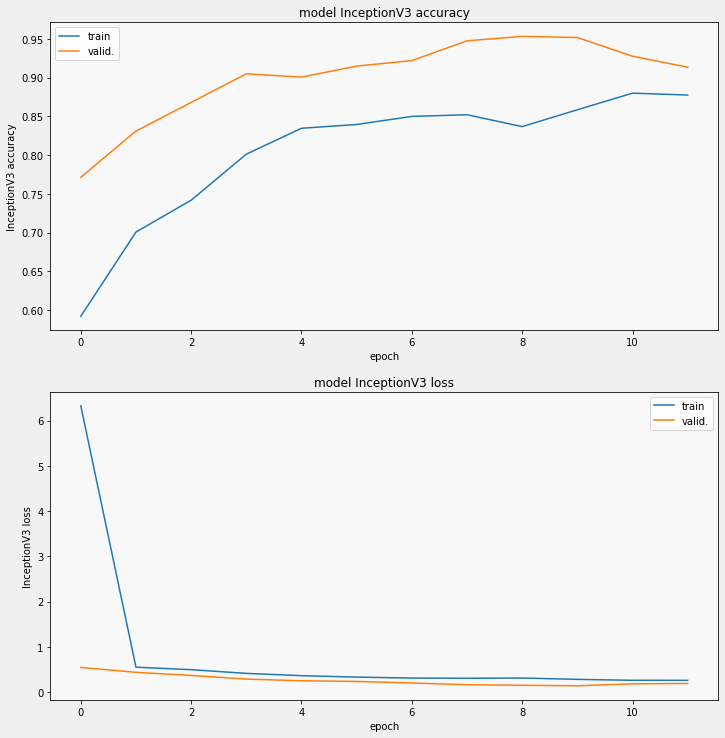

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'InceptionV3 accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'InceptionV3 loss', 212)

In [ ]:
training_details = [ 
        { 
        "Model": [{"Accuracy": model_MobileNetV2_accuracy, "Training Time": model_MobileNetV2_training_time} 
                   ], 
        "Name": "MobileNetV2"
        }, 
        { 
        "Model": [{"Accuracy": model_ResNet50V2_accuracy, "Training Time": model_ResNet50V2_training_time}                    
                  ], 
        "Name": "ResNet50V2"
        },
        { 
        "Model": [{"Accuracy": model_ResNet101V2_accuracy, "Training Time": model_ResNet101V2_training_time}                    
                  ], 
        "Name": "ResNet101V2"
        },
        { 
        "Model": [{"Accuracy": model_ResNet152V2_accuracy, "Training Time": model_ResNet152V2_training_time}                    
                  ], 
        "Name": "ResNet152V2"
        },
        { 
        "Model": [{"Accuracy": model_Xception_accuracy, "Training Time": model_Xception_training_time}                    
                  ], 
        "Name": "Xception"
        },
        { 
        "Model": [{"Accuracy": model_VGG16_accuracy, "Training Time": model_VGG16_training_time}                    
                  ], 
        "Name": "VGG16"
        },
        { 
        "Model": [{"Accuracy": model_VGG19_accuracy, "Training Time": model_VGG19_training_time}                    
                  ], 
        "Name": "VGG19"
        },
        { 
        "Model": [{"Accuracy": model_InceptionResNetV2_accuracy, "Training Time": model_InceptionResNetV2_training_time}                    
                  ], 
        "Name": "InceptionResNetV2"
        },
        { 
        "Model": [{"Accuracy": model_InceptionV3_accuracy, "Training Time": model_InceptionV3_training_time}                    
                  ], 
        "Name": "InceptionV3"
        }
       ] 

In [ ]:
training_details

[{'Model': [{'Accuracy': 0.99, 'Training Time': 93.8}], 'Name': 'MobileNetV2'},
 {'Model': [{'Accuracy': 0.99, 'Training Time': 144.48}],
  'Name': 'ResNet50V2'},
 {'Model': [{'Accuracy': 0.99, 'Training Time': 266.62}],
  'Name': 'ResNet101V2'},
 {'Model': [{'Accuracy': 0.99, 'Training Time': 388.98}],
  'Name': 'ResNet152V2'},
 {'Model': [{'Accuracy': 0.95, 'Training Time': 263.97}], 'Name': 'Xception'},
 {'Model': [{'Accuracy': 0.99, 'Training Time': 262.43}], 'Name': 'VGG16'},
 {'Model': [{'Accuracy': 0.96, 'Training Time': 262.46}], 'Name': 'VGG19'},
 {'Model': [{'Accuracy': 0.95, 'Training Time': 270.55}],
  'Name': 'InceptionResNetV2'},
 {'Model': [{'Accuracy': 0.94, 'Training Time': 112.21}],
  'Name': 'InceptionV3'}]

In [ ]:
model_MobileNetV2.save('/content/drive/MyDrive/dataset/us_MobileNetV2_Prostate.h5')
model_ResNet50V2.save('/content/drive/MyDrive/dataset/us_ResNet50V2_Prostate.h5')
model_ResNet101V2.save('/content/drive/MyDrive/dataset/us_ResNet101V2_Prostate.h5')
model_ResNet152V2.save('/content/drive/MyDrive/dataset/us_ResNet152V2_Prostate.h5')
model_InceptionResNetV2.save('/content/drive/MyDrive/dataset/us_InceptionResNetV2_Prostate.h5')
model_InceptionV3.save('/content/drive/MyDrive/dataset/us_InceptionV3_Prostate.h5')
model_Xception.save('/content/drive/MyDrive/dataset/us_model_Xception_Prostate.h5')
model_VGG16.save('/content/drive/MyDrive/dataset/us_model_VGG16_Prostate.h5')
model_VGG19.save('/content/drive/MyDrive/dataset/us_model_VGG19_Prostate.h5')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model_name=['MobileNetV2', 'ResNet50V2','ResNet101V2','ResNet152V2','Xception','VGG16','VGG19','InceptionResNetV2','InceptionV3']
model_accuracy=[model_MobileNetV2_accuracy, model_ResNet50V2_accuracy ,model_ResNet101V2_accuracy,model_ResNet152V2_accuracy,model_Xception_accuracy,model_VGG16_accuracy,model_VGG19_accuracy,model_InceptionResNetV2_accuracy,model_InceptionV3_accuracy]
model_training_time=[model_MobileNetV2_training_time,model_ResNet50V2_training_time,model_ResNet101V2_training_time,model_ResNet152V2_training_time,model_Xception_training_time,model_VGG16_training_time,model_VGG19_training_time,model_InceptionResNetV2_training_time,model_InceptionV3_training_time]

In [ ]:
import pandas as pd 

df = pd.DataFrame(list(zip(model_name, model_accuracy,model_training_time )), 
               columns =['Model Name', 'Accuracy', 'Training Time']) 
df 

Model Name  Accuracy  Training Time
0        MobileNetV2      0.99          93.80
1         ResNet50V2      0.99         144.48
2        ResNet101V2      0.99         266.62
3        ResNet152V2      0.99         388.98
4           Xception      0.95         263.97
5              VGG16      0.99         262.43
6              VGG19      0.96         262.46
7  InceptionResNetV2      0.95         270.55
8        InceptionV3      0.94         112.21

In [ ]:
df['Training Time'] = np.log(df['Training Time'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

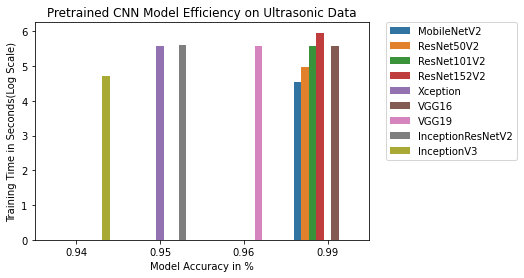

In [ ]:
ax=sns.barplot(y="Training Time", x="Accuracy", hue="Model Name", data=df)
ax.set_title('Pretrained CNN Model Efficiency on Ultrasonic Data')
ax.set_ylabel('Training Time in Seconds(Log Scale)')
ax.set_xlabel('Model Accuracy in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)